In [1]:
#XGBoost

#xgboost的安装、参数说明等详见https://xgboost.readthedocs.io/en/latest/index.html

#xgboost函数的主要调参参数包括(个人观点，仅供参考)：
#重要参数：
#num_round(最大迭代次数，没有默认值，必须要自己设定)
#seed(随机数种子，默认值为0)
#objective(任务目标，默认值为reg:linear)具体取值可查看help文档
# 二分类可设置为“binary:logistic”，其子模型为树，只是最后会将case的权重做Logistic变换以获得预测概率值
# 多分类可设置为“multi:softmax”，处理方式与二分类相同，只是用了softmax函数将权重转换为概率
# 回归可采用“reg:linear”
#max_depth(树的最大深度，默认值为6)：越大则树模型越复杂、越容易过拟合
#min_child_weight(叶节点中所有观测权重和的阈值，默认值为1)：小于该阈值时，树就不会再分裂；越大则模型越保守（不易过拟合）
#colsample_bytree(变量抽样比例，默认值为1)：越大则计算越耗时、树模型精度越高（但也可能导致过拟合）

#次重要参数：
#eta(学习率,默认值为0.3)：为了防止过拟合，更新过程中用到的收缩步长。在每次提升计算之后，
#   算法会直接获得新特征的权重, eta通过缩减特征的权重使提升计算过程更加保守。eta越大则模型越容易过拟合
#gamma(划分叶节点的损失变化量阈值，默认值为0) ：越大则模型越保守
#lambda(L2正则项系数，默认值为1)：越大则模型越保守
#alpha(L1正则项系数，默认值为0)：越大则模型越保守
#scale_pos_weight(处理类别不平衡的参数，默认值为1)
#subsample(观测值的抽样比例，默认值为1)：越大则模型越容易过拟合

#注意，若在scikit-learn框架下实现XGBoost，参数及其名称会略有不同（某些参数不会发生作用）

#必须处理定性变量！进行独热编码。
#不必处理缺失值。

In [4]:
#xgboost-回归问题：以R语言rpart包中car.test.frame数据为例。我将数据导出，存储为car.csv
import os
import pandas as pd
from sklearn.model_selection import train_test_split
alldata_X = pd.read_csv('Bootstrap1_feature_X(1).csv')
alldata_Y = pd.read_csv('Bootstrap1_feature_Y(1) - 副本.csv')
X_train, X_test, y_train, y_test = train_test_split(
    alldata_X, alldata_Y, test_size=1/3, random_state=1) #划分训练集和测试集；当y为定性变量时，可设置stratify=y进行分层抽样

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
import numpy as np

numeric_features = np.where(X_train.dtypes != object)[0]
categorical_features = np.where(X_train.dtypes == object)[0]
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(transformers=[('cat', categorical_transformer, categorical_features)])
X_trainonehot = pd.DataFrame(preprocessor.fit_transform(X_train))#定性变量独热编码
X_trainpreprocess = pd.DataFrame(np.hstack((X_train.iloc[:,numeric_features],X_trainonehot))) #与定量变量合并
X_train_dum = pd.get_dummies(X_train)
X_trainpreprocess.columns = X_train_dum.columns #借用get_dummies中的变量名
X_trainpreprocess.head()

,geo_index,floor_height,population_dense,supstructure,secondary_use,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,...,plan_configuration_m,plan_configuration_n,plan_configuration_o,plan_configuration_q,plan_configuration_s,plan_configuration_u,legal_ownership_status_a,legal_ownership_status_r,legal_ownership_status_v,legal_ownership_status_w
0,3.396615,3.0,0.100000,1.826379,2.0,2.0,100.0,10.0,6.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2.933261,2.0,0.166667,0.644443,0.0,2.0,20.0,6.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1.662047,2.0,0.166667,0.406598,2.0,1.0,5.0,6.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1.662047,2.0,0.166667,0.644443,0.0,2.0,5.0,6.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,2.623057,3.0,0.047619,0.882287,0.0,1.0,5.0,21.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [8]:
import numpy as np

# 假设模型返回的概率值存储在名为 `probs` 的数组中，形状为 (N, 3)，N 表示样本数量
probs = np.array([[0.3, 0.4, 0.3],  # 示例的概率值
                  [0.1, 0.2, 0.7],
                  [0.6, 0.2, 0.2]])

# 使用 softmax 函数计算概率分布
softmax_probs = np.exp(probs) / np.sum(np.exp(probs), axis=1, keepdims=True)

# 打印概率分布
print(softmax_probs)


predictions = np.argmax(softmax_probs, axis=1) + 1 
# 打印预测结果
print(predictions)


[[0.32204346 0.35591307 0.32204346]
 [0.25462853 0.28140804 0.46396343]
 [0.42723356 0.28638322 0.28638322]]
[2 3 1]


In [6]:
#第1种形式（原生形式），即不在scikit-learn框架下建模

import xgboost as xgb
#划分验证集val
X_train2, X_val, y_train2, y_val= train_test_split(
    X_trainpreprocess,y_train, test_size=1/3, random_state=1)

#转换数据
dtrain = xgb.DMatrix(X_train2, label=y_train2)
dval = xgb.DMatrix(X_val, label=y_val)

#设置模型参数并拟合模型
param = {'max_depth': 2, 'eta': 1, 'objective': "multi:softmax", "num_class": 3}
evallist = [(dtrain, 'train'),(dval, 'eval') ] 
#它是自动将最后一个数据集上的效果作为early stopping的指标，所以这个顺序不能颠倒
num_round = 50
reg = xgb.train(param, dtrain, num_round,evallist, early_stopping_rounds=5)
#注意，xgb.train()所获得的模型是最后一次迭代获得的模型，而不是最优的那个
#此例中，reg应是迭代了12次的模型，而非7次的模型

ModuleNotFoundError: No module named 'xgboost'

In [21]:
reg.predict(X_test) #early stopping下的最优RMSE

TypeError: ('Expecting data to be a DMatrix object, got: ', <class 'pandas.core.frame.DataFrame'>)

In [6]:
reg.best_iteration #early stopping下的最优迭代次数

7

In [7]:
reg.best_ntree_limit #early stopping下的基学习器个数

8

In [5]:
X_testonehot = pd.DataFrame(preprocessor.transform(X_test))#定性变量独热编码
X_testpreprocess = pd.DataFrame(np.hstack((X_test.iloc[:,numeric_features],X_testonehot))) #与定量变量合并
X_testpreprocess.columns = X_train_dum.columns #借用get_dummies中的变量名
dtest = xgb.DMatrix(X_testpreprocess)
y_pred = reg.predict(dtest, ntree_limit=reg.best_ntree_limit)

c:\Users\jessica\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


In [9]:
from sklearn.metrics import r2_score
r2_score(y_test,y_pred) #预测效果

0.8279433065146546

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

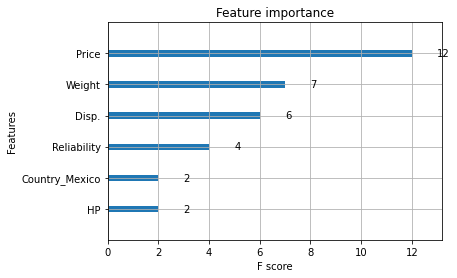

In [10]:
xgb.plot_importance(reg) #变量相对重要性

<AxesSubplot:>

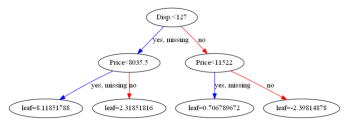

In [11]:
xgb.plot_tree(reg, num_trees=1) #画出其中的某一棵树（这里画的是第1棵），但这个图不清晰

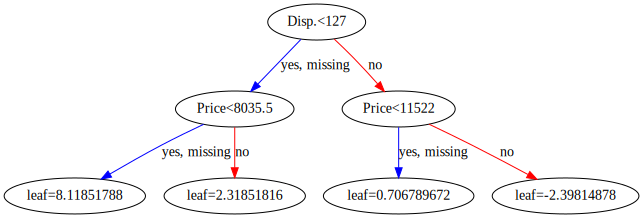

In [12]:
xgb.to_graphviz(reg,num_trees=1) #此图很清晰

In [6]:
#第2种形式（sklearn接口形式)，在scikit-learn框架下建模（但是参数及其名称会与上面略有不同）

from xgboost import XGBModel
reg_sk = XGBModel(n_estimators=50,max_depth=2, learning_rate=1, early_stopping_rounds=5, objective="multi:softmax", num_class=3)
#运行结果中会看到，early stopping不产生作用了
reg_sk.fit(X_train2, y_train2,
        eval_set=[(X_train2, y_train2), (X_val, y_val)],
        verbose=True)
y_pred_sk = reg_sk.predict(X_testpreprocess)
sum(y_pred_sk==y_test.values.reshape(-1))/len(y_pred_sk)#预测效果

[0]	validation_0-mlogloss:0.84019	validation_1-mlogloss:0.83790
[1]	validation_0-mlogloss:0.78186	validation_1-mlogloss:0.77901
[2]	validation_0-mlogloss:0.75323	validation_1-mlogloss:0.75073
[3]	validation_0-mlogloss:0.73937	validation_1-mlogloss:0.73736
[4]	validation_0-mlogloss:0.73082	validation_1-mlogloss:0.72885
[5]	validation_0-mlogloss:0.72476	validation_1-mlogloss:0.72331
[6]	validation_0-mlogloss:0.72035	validation_1-mlogloss:0.71964
[7]	validation_0-mlogloss:0.71671	validation_1-mlogloss:0.71624
[8]	validation_0-mlogloss:0.71290	validation_1-mlogloss:0.71260
[9]	validation_0-mlogloss:0.71048	validation_1-mlogloss:0.71076
[10]	validation_0-mlogloss:0.70803	validation_1-mlogloss:0.70867
[11]	validation_0-mlogloss:0.70648	validation_1-mlogloss:0.70722
[12]	validation_0-mlogloss:0.70455	validation_1-mlogloss:0.70535
[13]	validation_0-mlogloss:0.70087	validation_1-mlogloss:0.70198
[14]	validation_0-mlogloss:0.69945	validation_1-mlogloss:0.70072
[15]	validation_0-mlogloss:0.69618	

0.6930428571428572

Text(0.5, 1.0, 'Variances Importances')

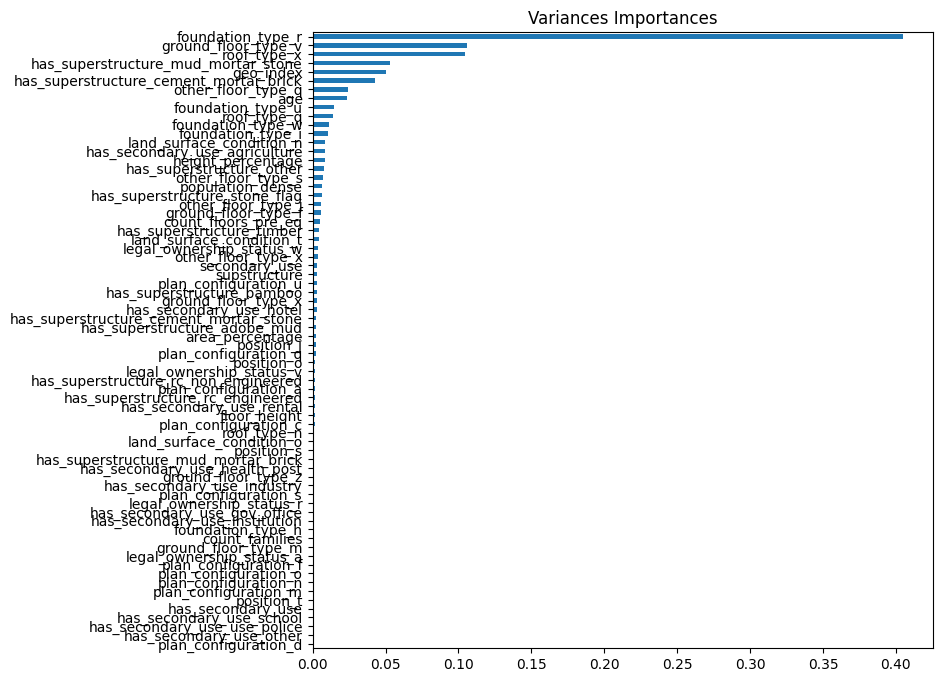

In [9]:
import matplotlib.pyplot as plt
reg_importance = pd.Series(reg_sk.feature_importances_,index = X_train_dum.columns, name = 'Var')

plt.figure(figsize=(8,8))
reg_importance.sort_values().plot(kind='barh')
plt.title("Variances Importances")

In [7]:
#采用交叉验证选取最优参数，这里选取n_estimators
from sklearn.model_selection import GridSearchCV, KFold
a=[]
for j in range(100,1000,100):
    a.append(j)
    
reg_sk = XGBModel(max_depth=3, learning_rate=1, verbosity=0, objective="multi:softmax", num_class=3) 

#若不设置verbosity=0，下面会许多warning，说reg:linear过时了应使用'reg:squarederror', 还说reg_sk__n_estimators可能不发生作用
param_grid=[{'reg_sk__n_estimators':a}] #一定要注意clf后面是两根下划线！

gs = GridSearchCV(estimator=reg_sk,
               param_grid=param_grid,
               scoring='accuracy',
               cv=KFold(n_splits=3, random_state=1, shuffle=True))
clf = gs.fit(X_trainpreprocess,y_train)

In [23]:
clf.best_params_ #最佳参数组合


{'reg_sk__n_estimators': 100}

In [13]:
y_test

,label
113124,0
96489,0
128829,2
191776,2
59302,2
...,...
148063,2
113561,0
178291,0
123802,0


In [34]:
sum(clf.predict(X_test)==y_test.values.reshape(-1))/len(y_test)



0.7184285714285714

In [18]:
#采用交叉验证选取最优参数，这里选取n_estimators
from sklearn.model_selection import GridSearchCV, KFold
a=[]
for j in range(30,150,10):
    a.append(j)
    
reg_sk = XGBModel(max_depth=3, learning_rate=1, verbosity=0, objective="multi:softmax", num_class=3) 
#若不设置verbosity=0，下面会许多warning，说reg:linear过时了应使用'reg:squarederror', 还说reg_sk__n_estimators可能不发生作用
param_grid=[{'reg_sk__n_estimators':a}] #一定要注意clf后面是两根下划线！

gs = GridSearchCV(estimator=reg_sk,
               param_grid=param_grid,
               scoring='accuracy',
               cv=KFold(n_splits=3, random_state=1, shuffle=True))
gs = gs.fit(X_trainpreprocess,y_train)

In [30]:
gs.best_params_ #最佳参数组合

{'reg_sk__n_estimators': 30}

In [37]:
sum(gs.predict(X_test)==y_test.values.reshape(-1))/len(y_test)

0.7184285714285714

In [16]:
#采用交叉验证选取最优参数，这里选取n_estimators
from sklearn.model_selection import GridSearchCV, KFold
a=[]
for j in range(5,30,5):
    a.append(j)
    
reg_sk = XGBModel(max_depth=5, learning_rate=1, verbosity=0, objective="multi:softmax", num_class=3) 
#若不设置verbosity=0，下面会许多warning，说reg:linear过时了应使用'reg:squarederror', 还说reg_sk__n_estimators可能不发生作用
param_grid=[{'reg_sk__n_estimators':a}] #一定要注意clf后面是两根下划线！

gs = GridSearchCV(estimator=reg_sk,
               param_grid=param_grid,
               scoring='accuracy',
               cv=KFold(n_splits=5, random_state=1, shuffle=True))
gs = gs.fit(X_trainpreprocess,y_train)

In [25]:
#采用交叉验证选取最优参数，这里选取n_estimators
from sklearn.model_selection import GridSearchCV, KFold
a=[]
for j in range(1,5):
    a.append(j)
    
reg_sk = XGBModel(max_depth=5, learning_rate=1, verbosity=0, objective="multi:softmax", num_class=3) 
#若不设置verbosity=0，下面会许多warning，说reg:linear过时了应使用'reg:squarederror', 还说reg_sk__n_estimators可能不发生作用
param_grid=[{'reg_sk__n_estimators':a}] #一定要注意clf后面是两根下划线！

gs = GridSearchCV(estimator=reg_sk,
               param_grid=param_grid,
               scoring='accuracy',
               cv=KFold(n_splits=5, random_state=1, shuffle=True))
gs = gs.fit(X_trainpreprocess,y_train)

[07:53:15] ======== Monitor (0): Learner ========
[07:53:15] ======== Monitor (0):  ========
[07:53:15] ======== Monitor (0): TreePruner ========


In [19]:
gs.best_params_ #最佳参数组合

{'reg_sk__n_estimators': 1}

In [24]:
gs.best_score_ #最佳参数组合下的R-squared

0.7189142719610154

In [18]:
gs.cv_results_

{'mean_fit_time': array([0.05335653, 0.05385625, 0.05684781, 0.05236018, 0.052858  ,
        0.05335808, 0.05385613, 0.05684769, 0.05535173, 0.05734646,
        0.05385506, 0.0538559 , 0.0548526 , 0.0553515 , 0.05784798,
        0.05485332, 0.05485284, 0.05435431, 0.0538553 ]),
 'std_fit_time': array([4.99129295e-04, 9.97185707e-04, 3.98898125e-03, 4.98890877e-04,
        3.57627869e-07, 4.98533249e-04, 1.99413300e-03, 1.19209290e-07,
        4.98771667e-04, 3.49104404e-03, 9.96708870e-04, 2.38418579e-07,
        3.57627869e-07, 4.99010086e-04, 2.99453735e-03, 3.57627869e-07,
        5.96046448e-07, 1.49691105e-03, 1.31130219e-06]),
 'mean_score_time': array([0.01097071, 0.0119679 , 0.01097107, 0.01146924, 0.01097035,
        0.01146889, 0.01047194, 0.01047194, 0.01146972, 0.01047182,
        0.0114696 , 0.01147664, 0.01097214, 0.01097143, 0.01146674,
        0.01146984, 0.01196849, 0.01097143, 0.01097059]),
 'std_score_time': array([5.96046448e-07, 9.96589661e-04, 4.76837158e-07, 4.98

In [19]:
gs.best_estimator_

XGBModel(base_score=0.5, booster='gbtree', colsample_bylevel=1,
         colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
         interaction_constraints='', learning_rate=1, max_delta_step=0,
         max_depth=2, min_child_weight=1, monotone_constraints='()', n_jobs=8,
         num_parallel_tree=1, objective='reg:squarederror', random_state=0,
         reg_alpha=0, reg_lambda=1, reg_sk__n_estimators=1, scale_pos_weight=1,
         subsample=1, tree_method='exact', validate_parameters=1, verbosity=0)

In [30]:
#使用最优参数做预测
reg_sk = gs.best_estimator_
reg_sk.fit(X_trainpreprocess, y_train)
y_pred = reg_sk.predict(X_testpreprocess)
sum(y_pred==y_test.values.reshape(-1))/len(y_pred)

0.7011648533984446

In [21]:
#试试嵌套交叉验证下的效果
from sklearn.model_selection import GridSearchCV,cross_val_score

gs=GridSearchCV(estimator=reg_sk,
               param_grid=param_grid,
               scoring='r2', 
               cv=KFold(n_splits=2, random_state=1, shuffle=True))

X_onehot = pd.DataFrame(preprocessor.transform(X).toarray())#定性变量独热编码
X_preprocess = pd.DataFrame(np.hstack((X.iloc[:,numeric_features],X_onehot))) #与定量变量合并
X_preprocess.columns = X_train_dum.columns #借用get_dummies中的变量名

scores = cross_val_score(gs,X_preprocess,y,scoring='r2',cv=KFold(n_splits=3, random_state=1, shuffle=True)) #注意，这里应该用所有的数据，而不能是之前划分的训练集X_train
print('CV R2 of Tree: %.3f +/- %.3f' % (np.mean(scores),np.std(scores)))
scores 

CV R2 of Tree: 0.565 +/- 0.151


array([0.72408384, 0.60702087, 0.36240957])

In [22]:
#也可以使用xgboost.XGBRegressor()在scikit-learn中实现回归，与XGBModel结果相同（详情略）